For Wednesday: 
-leave in XGBoost with just wind speed 
-We know the before values 
-run this model when next hurricane hits and validate it against the data 
-run it on hurricane ian data 
-run it with just size rank to just see if it substantially drops 
-compare F1 score of SizeRank and Wind Speed to see how much information is being added 




# Obtaining Data

In [1]:
#Importing libraries needed
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# For demonstrative pruposes
from scipy.special import logit, expit

# To show variable values in markdown
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

In [2]:
#opening the datasets 
bottom =  pd.read_csv(r'data\bottom_hurricane.csv')
middle =  pd.read_csv(r'data\middle_hurricane.csv')
top =  pd.read_csv(r'data\top_hurricane.csv')
all_df = pd.read_csv(r'data\all_hurricane.csv')

In [3]:
bottom.describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,17.050417,32.820248,836.427252,95603.235456,110462.544534,16.765446,0.369515
std,13.009195,22.912817,2127.208992,33766.654876,35707.591357,7.402668,0.483232
min,4.030000,0.000000,12.000000,33025.679010,41196.088340,1.715556,0.000000
25%,9.170000,19.900000,84.000000,71026.657360,83003.431000,11.465540,0.000000
50%,13.200000,25.100000,190.000000,90687.074960,107991.152200,16.018972,0.000000
75%,19.460000,36.900000,704.000000,117150.037000,135916.268400,20.412881,1.000000
max,91.064199,194.610300,12877.000000,217713.978800,246535.290800,38.720009,1.000000


In [4]:
bottom.max()

City             Winter Haven
HurricaneName         michael
DATE                 9/9/2017
AWND                91.064199
WSF2                 194.6103
SizeRank                12877
before            217713.9788
after             246535.2908
percent             38.720009
increase                    1
dtype: object

In [5]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all_df = all_df.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [6]:
#We want to remove ian from the datasets because we will need it to validate our model later 

#let's save a dataframe that has just Ian 
all_ian = all_df.loc[all_df['HurricaneName'] == 'ian']
all_ian.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,ian,9/28/2022,38.027300,57.93571,12877,65287.07867,76710.34737,17.496982,1
98,Fort Pierce,ian,9/28/2022,50.039453,100.66050,529,79706.02938,93971.25035,17.897292,1
179,Lakeland,ian,9/28/2022,51.538176,105.13430,105,92333.43871,109089.32580,18.147149,1
188,Leesburg,ian,9/29/2022,48.540730,91.48921,1024,89188.23594,102166.59930,14.551654,1
203,Miami,ian,9/28/2022,41.539233,69.56759,20,187941.97110,204898.39500,9.022159,0


In [7]:
#removing ian from the other datasets
bottom = bottom.drop(bottom[bottom['HurricaneName'] == 'ian'].index)
middle = middle.drop(middle[middle['HurricaneName'] == 'ian'].index)
top = top.drop(top[top['HurricaneName'] == 'ian'].index)
all_df = all_df.drop(all_df[all_df['HurricaneName'] == 'ian'].index)

In [8]:
bottom

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,5.82,13.0,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,19.46,30.0,12877,40369.46137,50891.84431,26.065205,0
4,Apalachicola,irma,9/11/2017,20.80,36.9,12877,52379.75722,63594.00344,21.409504,1
7,Apalachicola,matthew,10/7/2016,10.74,21.9,12877,48548.85811,52980.36723,9.127937,0
9,Apalachicola,michael,10/10/2018,29.75,63.1,12877,65287.07867,76710.34737,17.496982,1
...,...,...,...,...,...,...,...,...,...,...
421,West Palm Beach,michael,10/9/2018,13.65,23.0,158,131859.03710,143536.42570,8.855964,0
422,Winter Haven,dennis,7/10/2005,13.65,25.1,395,59886.01537,76763.92735,28.183395,0
426,Winter Haven,irma,9/10/2017,25.95,55.0,395,80030.41335,93036.50736,16.251439,1
428,Winter Haven,matthew,10/7/2016,13.42,25.9,395,69267.39054,80862.30360,16.739353,1


In [9]:
middle

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,5.82,13.0,12877,91915.39335,114408.1491,24.471152,1
1,Apalachicola,dennis,7/10/2005,19.46,30.0,12877,112287.89680,140227.0087,24.881677,0
4,Apalachicola,irma,9/11/2017,20.80,36.9,12877,127923.42670,142053.1799,11.045477,0
7,Apalachicola,matthew,10/7/2016,10.74,21.9,12877,124938.95560,128831.4366,3.115506,0
9,Apalachicola,michael,10/10/2018,29.75,63.1,12877,144565.87220,161515.9275,11.724797,1
...,...,...,...,...,...,...,...,...,...,...
413,West Palm Beach,charley,8/13/2004,12.75,31.1,158,156234.53760,191100.1557,22.316204,0
415,West Palm Beach,dennis,7/10/2005,15.88,34.9,158,187824.49660,240703.5672,28.153447,0
419,West Palm Beach,irma,9/10/2017,38.92,66.0,158,214427.89250,234149.5014,9.197315,0
421,West Palm Beach,matthew,10/7/2016,19.69,31.1,158,197641.97590,216511.5252,9.547339,0


In [10]:
top

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,5.82,13.0,12877,221794.3003,275297.2698,24.122788,1
1,Apalachicola,dennis,7/10/2005,19.46,30.0,12877,269923.5452,339439.8016,25.754054,0
4,Apalachicola,irma,9/11/2017,20.80,36.9,12877,257605.2886,276477.8214,7.326143,0
7,Apalachicola,matthew,10/7/2016,10.74,21.9,12877,255217.2827,259168.4086,1.548142,0
9,Apalachicola,michael,10/10/2018,29.75,63.1,12877,279871.2479,308859.8100,10.357821,1
...,...,...,...,...,...,...,...,...,...,...
422,West Palm Beach,charley,8/13/2004,12.75,31.1,158,337513.4241,408594.3455,21.060176,0
424,West Palm Beach,dennis,7/10/2005,15.88,34.9,158,401684.3542,509416.8784,26.820194,0
428,West Palm Beach,irma,9/10/2017,38.92,66.0,158,390818.9715,413213.8804,5.730251,0
430,West Palm Beach,matthew,10/7/2016,19.69,31.1,158,375111.3104,393070.8116,4.787779,0


In [11]:
all

<function all(iterable, /)>

## Checking Crosstabs

### Bottom Tier Home Values

In [12]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,16.828333,31.587500,778.479167,95519.992225,109226.353419,15.737500,0.0
std,7.510509,13.880939,1933.043703,36589.222256,38580.694737,7.428945,0.0
min,4.700000,0.000000,12.000000,35072.914710,42936.584540,1.715556,0.0
25%,12.750000,23.000000,109.000000,67085.771493,77117.054463,9.294061,0.0
50%,14.430000,26.950000,219.000000,87921.154230,106197.766650,13.545954,0.0
75%,19.460000,36.000000,714.000000,124777.238250,137188.222700,21.427859,0.0
max,40.260000,79.000000,12877.000000,187941.971100,204898.395000,31.148843,0.0


In [13]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,19.71000,36.360000,1614.733333,81869.675339,99918.350911,22.208175,1.0
std,7.55599,14.072933,3251.236781,22972.899025,28216.775660,6.973273,0.0
min,5.82000,13.000000,12.000000,33025.679010,41196.088340,12.376811,1.0
25%,13.87000,25.900000,105.000000,65732.062590,78209.741850,17.496982,1.0
50%,19.46000,31.100000,350.000000,79706.029380,97547.957590,19.823318,1.0
75%,23.71000,52.100000,1343.000000,94132.640630,113361.292200,24.912005,1.0
max,40.71000,70.900000,12877.000000,137614.499600,166366.441400,38.720009,1.0


### Middle Tier Home Values

In [14]:
#check crosstabs 
middle[middle['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0
mean,17.192736,32.578302,1196.764151,178788.700647,200015.445600,12.739620,0.0
std,7.398756,13.286456,2875.059325,57253.054213,60012.616564,8.166830,0.0
min,4.700000,10.100000,12.000000,47433.413480,55475.026340,-0.304135,0.0
25%,12.750000,23.900000,106.000000,140195.814075,158385.796575,6.516116,0.0
50%,14.760000,29.100000,219.000000,168077.713500,188779.652850,10.175417,0.0
75%,20.525000,36.900000,744.000000,214175.896200,235810.160275,19.340890,0.0
max,38.920000,79.000000,12877.000000,328091.109800,346404.378100,30.423110,0.0


In [15]:
#check crosstabs 
middle[middle['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,19.468182,33.951515,2376.212121,152609.677086,183012.972018,19.750077,1.0
std,9.052282,16.306749,3966.086317,45215.695236,58301.939354,9.054438,0.0
min,4.470000,0.000000,12.000000,38971.285380,48205.342730,8.693131,1.0
25%,13.650000,23.900000,299.000000,131341.028200,147305.080700,11.724797,1.0
50%,16.780000,30.000000,529.000000,153995.650000,185899.410500,14.943632,1.0
75%,24.610000,46.100000,1644.000000,184197.828400,211150.410200,27.524342,1.0
max,40.710000,70.900000,12877.000000,237636.125500,316361.491800,34.925821,1.0


### Top Tier Home Values

In [16]:
#check crosstabs 
top[top['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,17.763947,33.115789,1225.184211,328449.969281,360988.239664,10.473163,0.0
std,7.852753,13.802145,2961.979981,113947.912364,122569.498236,8.631772,0.0
min,4.470000,8.100000,12.000000,98118.000900,119490.997200,-4.161603,0.0
25%,12.970000,23.900000,93.000000,246799.050675,271226.589675,4.737962,0.0
50%,15.100000,29.100000,190.000000,315968.313150,350767.209850,5.958488,0.0
75%,20.800000,38.000000,744.000000,382389.195500,418708.970725,17.504185,0.0
max,40.260000,79.000000,12877.000000,671004.028700,768214.341700,27.655345,0.0


In [17]:
#check crosstabs 
top[top['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,17.624286,32.192857,2354.142857,273379.316779,326346.226943,18.132019,1.0
std,7.603506,14.464181,3809.242403,76774.203448,110181.403979,10.229255,0.0
min,5.820000,13.000000,16.000000,130756.896600,140391.373400,6.722834,1.0
25%,13.142500,23.675000,299.000000,231229.432300,255309.653800,7.967553,1.0
50%,14.875000,28.000000,636.500000,252692.063600,311156.525200,18.205906,1.0
75%,21.922500,34.325000,1927.000000,315217.170000,372749.758575,28.046185,1.0
max,40.710000,70.900000,12877.000000,457389.673300,605350.754900,33.863819,1.0


### All Home Values 

In [18]:
#check crosstabs 
all_df[all_df['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0
mean,13.768992,27.177907,1191.391473,212575.987928,234000.852403,11.890184,0.0
std,6.939955,12.531378,2873.375161,124254.783285,131099.520669,8.078201,0.0
min,2.910000,0.000000,12.000000,45314.651590,52157.021900,-4.161603,0.0
25%,8.720000,18.100000,106.000000,117276.771100,135580.557625,5.582217,0.0
50%,12.190000,23.900000,219.000000,184998.996100,205368.325550,9.188158,0.0
75%,16.722500,31.100000,744.000000,278446.944025,311384.740025,17.445984,0.0
max,38.920000,79.000000,12877.000000,638691.713200,669502.004200,30.676022,0.0


In [19]:
#check crosstabs 
all_df[all_df['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.0
mean,14.880814,27.886047,1861.965116,146638.094252,174430.381725,19.463055,1.0
std,7.205503,13.217672,3396.683491,83327.546857,100276.415300,8.625308,0.0
min,4.920000,6.900000,12.000000,44457.567490,55432.846820,6.722834,1.0
25%,9.282500,18.100000,107.750000,80030.413350,93270.193108,12.500773,1.0
50%,13.650000,24.500000,462.000000,126538.414750,148023.322150,17.719562,1.0
75%,18.570000,31.775000,1410.000000,190034.211300,219513.525825,25.149288,1.0
max,40.710000,70.900000,12877.000000,372909.443500,488064.017600,38.720009,1.0


### Examining Class Imbalance

|dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|bottom tier| 45 | 96| 68% |
|middle tier| 33 | 106 | 76% |
|top tier| 28 | 114 | 80% |
|all| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


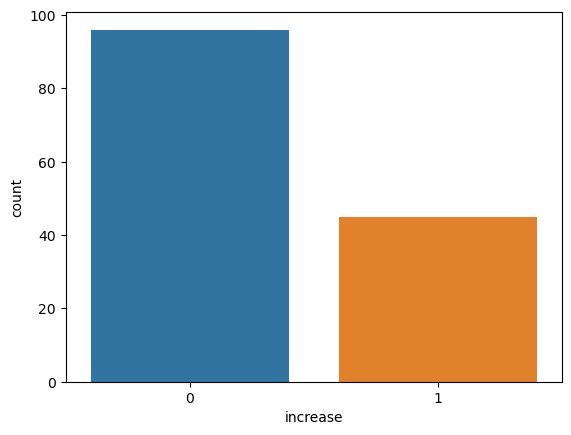

In [20]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom);
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


#### Middle Tier Class Imbalance

0    106
1     33
Name: increase, dtype: int64
majority percent is 76.2589928057554 %


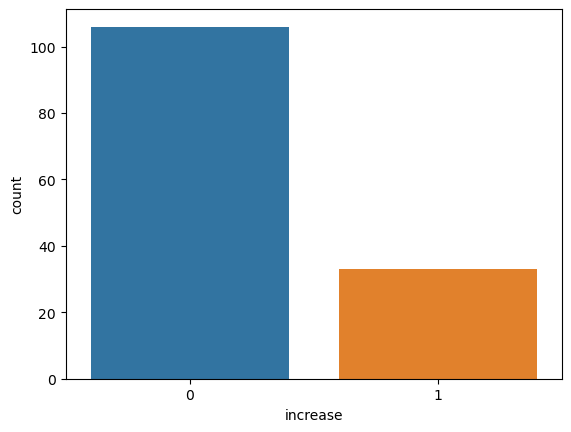

In [21]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle);
print(middle['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle['increase']) - middle['increase'].sum())/(len(middle['increase']) - middle['increase'].sum()+middle['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

0    114
1     28
Name: increase, dtype: int64
majority percent is 80.28169014084507 %


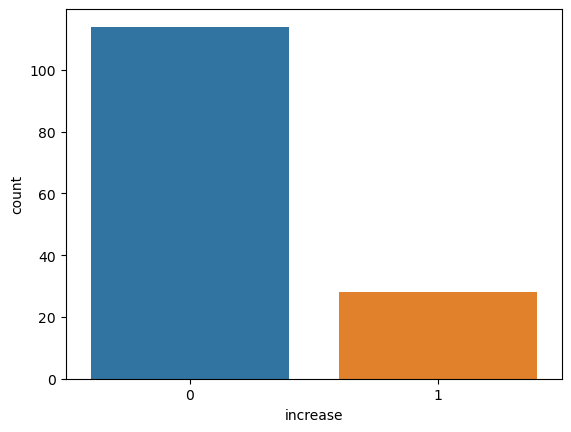

In [22]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top);
print(top['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top['increase']) - top['increase'].sum())/(len(top['increase']) - top['increase'].sum()+top['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

0    258
1     86
Name: increase, dtype: int64
majority percent is 75.0 %


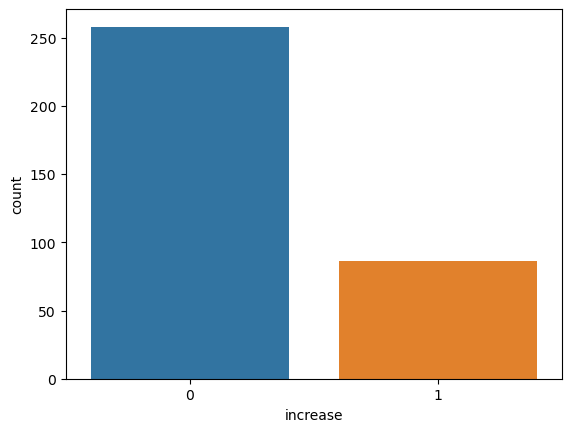

In [23]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all_df);
print(all_df['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_df['increase']) - all_df['increase'].sum())/(len(all_df['increase']) - all_df['increase'].sum()+all_df['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

# Logistic Regression

In [24]:
#establishing model 
logreg = LogisticRegression(random_state=56)

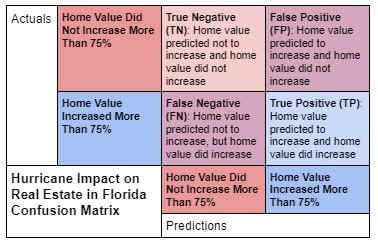

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance. 

In [25]:
bottom.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
0,Apalachicola,charley,8/14/2004,5.82,13.0,12877,33025.67901,41196.08834,24.739565,1
1,Apalachicola,dennis,7/10/2005,19.46,30.0,12877,40369.46137,50891.84431,26.065205,0
4,Apalachicola,irma,9/11/2017,20.80,36.9,12877,52379.75722,63594.00344,21.409504,1
7,Apalachicola,matthew,10/7/2016,10.74,21.9,12877,48548.85811,52980.36723,9.127937,0
9,Apalachicola,michael,10/10/2018,29.75,63.1,12877,65287.07867,76710.34737,17.496982,1


### Selecting Our Target Variable and Features
Our targer variable is increase and for our first iteration of modeling we will use all the available features. 

In [26]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [27]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [28]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Training Data

In [29]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [30]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [31]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [32]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [33]:
#Printing Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_test)
print(accuracy_1)

0.7441860465116279


In [34]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_1 = f1_score(y_test, y_pred_test)
print(F1_1)

0.35294117647058826


In [35]:
model_dict = {}
model_dict['Baseline Accuracy'] = percent_bottom
model_dict['LGRModel1_Accuracy'] = accuracy_1
model_dict['LGRModel1_F1'] = F1_1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826}

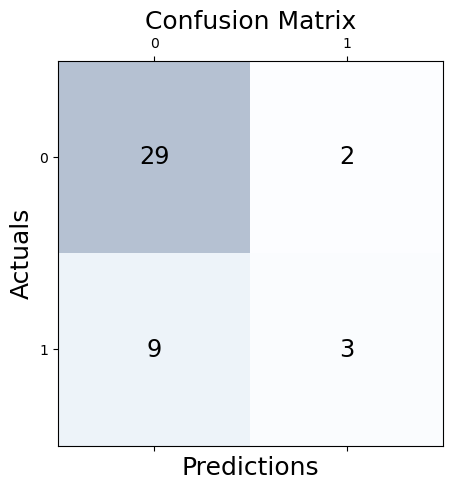

In [36]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

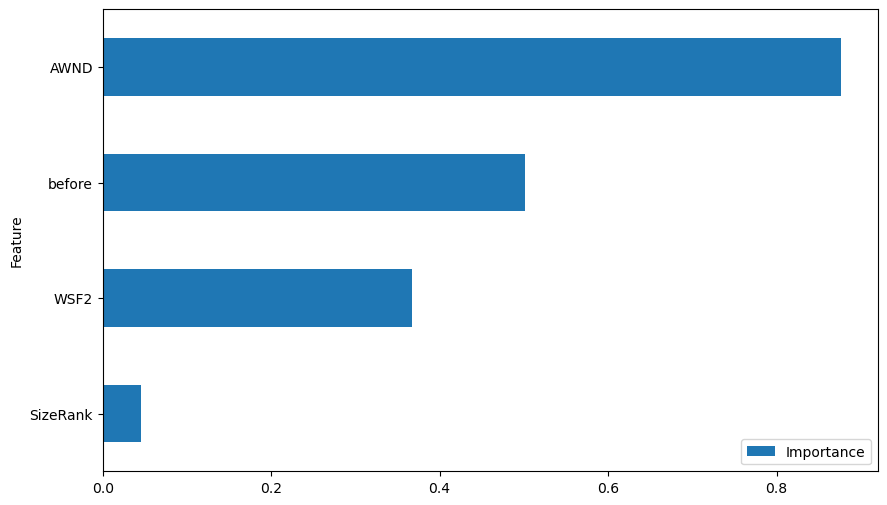

In [37]:
#https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression
#checking out feature importance

model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [38]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [39]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [40]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [41]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [42]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [43]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [44]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [45]:
#Printing Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_test)
print(accuracy_2)

0.7674418604651163


In [46]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_2 = f1_score(y_test, y_pred_test)
print(F1_2)

0.375


### Saving to Dictionary

In [47]:

model_dict['LGRModel2_Accuracy'] = accuracy_2
model_dict['LGRModel2_F1'] = F1_2
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375}

### Confusion Matrix

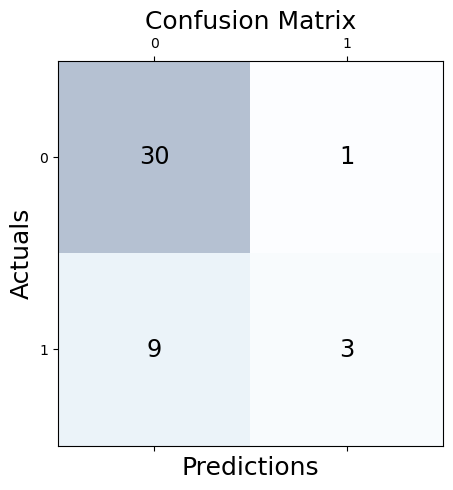

In [48]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

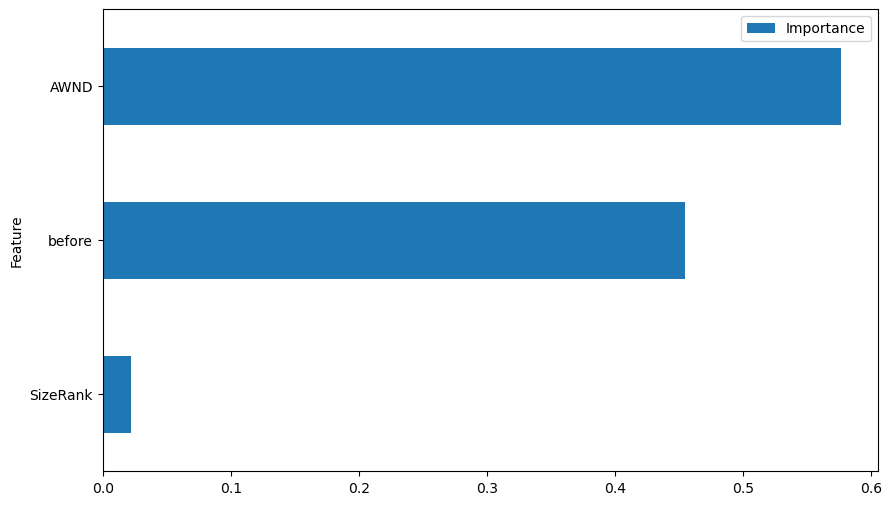

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Model 3: Bottom Tier Housing with Smote 

In [50]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [51]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [52]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### SMOTE

In [53]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE(random_state=56)

In [54]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [55]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 1    65
0    65
Name: increase, dtype: int64


### Training Data

In [56]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

In [57]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.662


In [58]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.656


### Testing Data

In [59]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

In [60]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

0.8064516129032258


In [61]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

0.8064516129032258


In [62]:
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.8064516129032258,
 'LGRModel3_F1': 0.8064516129032258}

### Confusion Matrix

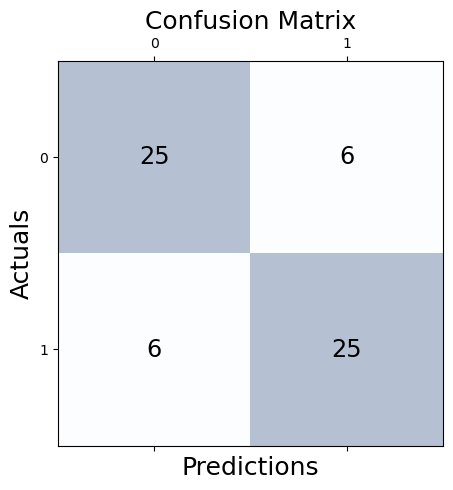

In [63]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Feature Importance

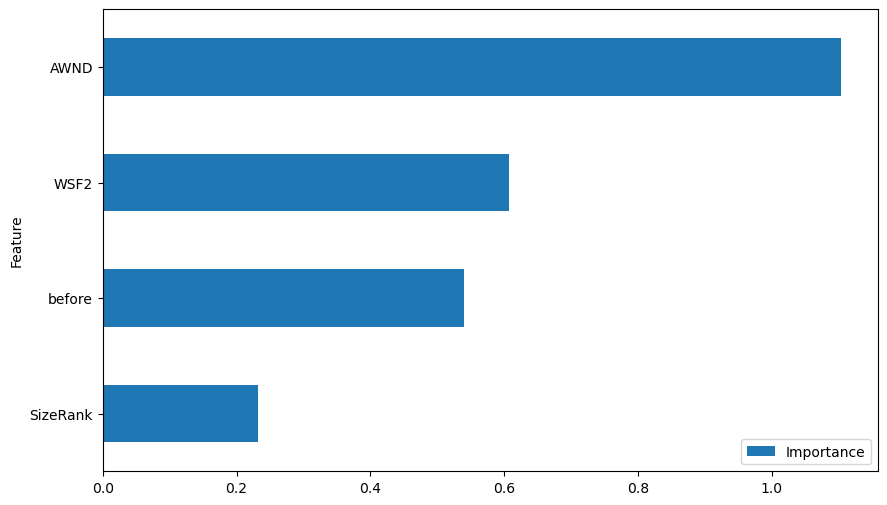

In [64]:
model = LogisticRegression()
model.fit(SMOTE_X_train, SMOTE_y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## XGBoost

In [196]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
xgb = xgb.XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

In [197]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)


In [198]:
X_boost.head()

,AWND,WSF2,SizeRank,before
0,5.82,13.0,12877,33025.67901
1,19.46,30.0,12877,40369.46137
4,20.80,36.9,12877,52379.75722
7,10.74,21.9,12877,48548.85811
9,29.75,63.1,12877,65287.07867


### Train/Test Split

In [199]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [200]:
xgb.fit(XG_X_train, XG_y_train);

In [201]:
y_pred_train = xgb.predict(XG_X_train)

In [202]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [203]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [204]:
xgb.fit(XG_X_test, XG_y_test);

In [205]:
y_pred_test = xgb.predict(XG_X_test)

In [206]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

1.0


In [207]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

1.0


In [208]:
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.8064516129032258,
 'LGRModel3_F1': 0.8064516129032258,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0,
 'XGBoost_Accuracy_No_Wind': 0.9534883720930233,
 'XGBoost_F1_No_Wind': 0.9090909090909091}

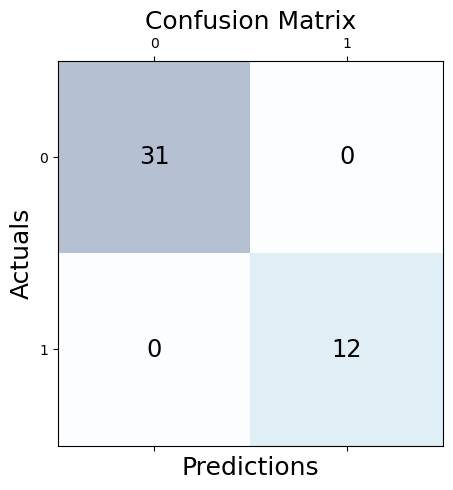

In [209]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

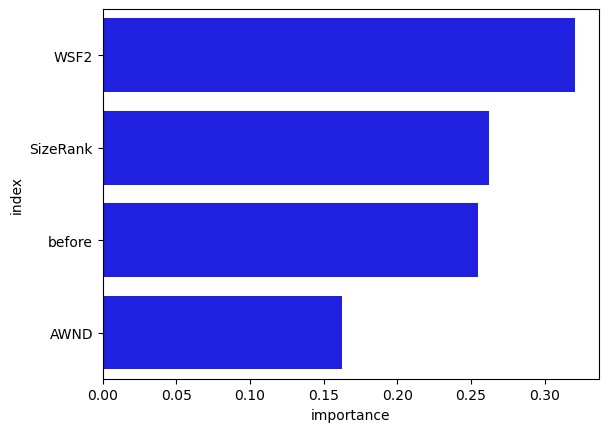

In [210]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

# How Do Wind Speed Features Impact Model Performance
For the scope of this project we are particularily interested in how hurricane's impact real estate value. Using wind speed we were able to gauge how much damage a hurricane had on a certain area. The most important feature for our best model was fastest 2 minute wind gust and SizeRank. When we drop the wind features from the model the accuracy drops to 0.95 and the F1 score drops to 0.90. 

### Selecting Our Target Variable and Features

In [303]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2', 'AWND'], axis=1)


In [304]:
X_boost.head()

,SizeRank,before
0,12877,33025.67901
1,12877,40369.46137
4,12877,52379.75722
7,12877,48548.85811
9,12877,65287.07867


### Train/Test Split

In [305]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [306]:
xgb.fit(XG_X_train, XG_y_train);

In [307]:
y_pred_train = xgb.predict(XG_X_train)

In [308]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [309]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [310]:
xgb.fit(XG_X_test, XG_y_test);

In [311]:
y_pred_test = xgb.predict(XG_X_test)

In [312]:
#Printing Accuracy
accuracy_XGW = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XGW)

0.9534883720930233


In [313]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XGW = f1_score(XG_y_test, y_pred_test)
print(F1_XGW)

0.9090909090909091


In [314]:
model_dict['XGBoost_Accuracy_No_Wind'] = accuracy_XGW
model_dict['XGBoost_F1_No_Wind'] = F1_XGW
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.8064516129032258,
 'LGRModel3_F1': 0.8064516129032258,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0,
 'XGBoost_Accuracy_No_Wind': 0.9534883720930233,
 'XGBoost_F1_No_Wind': 0.9090909090909091}

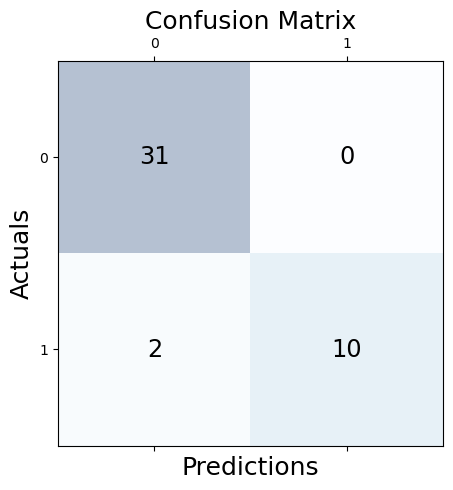

In [315]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

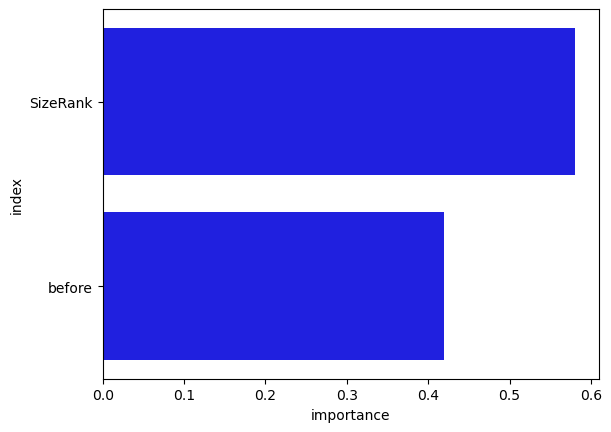

In [316]:
#seeing what features are most important to housing value
#Using feature importance 
feature_importances = xgb.feature_importances_

# Create a list of features
feature_list = list(X_boost.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model had an accuracy of 72% which is only slightly better than the majority percent of 68%. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before 

In [317]:
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.8064516129032258,
 'LGRModel3_F1': 0.8064516129032258,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0,
 'XGBoost_Accuracy_No_Wind': 0.9534883720930233,
 'XGBoost_F1_No_Wind': 0.9090909090909091}

## XGBoost on All Data

Now that we have our model, let's see how it performs on other data. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [318]:
all_df

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
6,Apalachicola,irma,9/9/2017,12.97,19.9,12877,52379.75722,63594.00344,21.409504,1
7,Apalachicola,matthew,10/7/2016,10.74,21.9,12877,48548.85811,52980.36723,9.127937,0
13,Brooksville,dennis,7/10/2005,13.42,28.0,1410,57099.70044,74016.75109,29.627214,0
16,Brooksville,irma,9/10/2017,20.80,42.9,1410,60059.47846,71868.12810,19.661592,1
17,Brooksville,irma,9/9/2017,13.87,25.9,1410,60059.47846,71868.12810,19.661592,1
...,...,...,...,...,...,...,...,...,...,...
1283,West Palm Beach,dennis,7/10/2005,15.88,34.9,158,401684.35420,509416.87840,26.820194,0
1284,West Palm Beach,dennis,7/11/2005,8.50,15.0,158,401684.35420,509416.87840,26.820194,0
1286,West Palm Beach,irma,9/11/2017,17.00,40.9,158,390818.97150,413213.88040,5.730251,0
1292,West Palm Beach,michael,10/10/2018,12.75,25.1,158,414414.18150,434088.96000,4.747612,0


In [319]:
#y is prediction variable 
#X is features 
y_boost = all_df['increase']
X_boost = all_df.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [320]:
X_boost

,AWND,WSF2,SizeRank,before
6,12.97,19.9,12877,52379.75722
7,10.74,21.9,12877,48548.85811
13,13.42,28.0,1410,57099.70044
16,20.80,42.9,1410,60059.47846
17,13.87,25.9,1410,60059.47846
...,...,...,...,...
1283,15.88,34.9,158,401684.35420
1284,8.50,15.0,158,401684.35420
1286,17.00,40.9,158,390818.97150
1292,12.75,25.1,158,414414.18150


In [321]:
#performing train test split 
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

In [322]:
xgb.fit(XG_X_train, XG_y_train);

In [323]:
y_pred_train = xgb.predict(XG_X_train)

In [324]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [325]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


In [326]:
xgb.fit(XG_X_test, XG_y_test);

In [327]:
y_pred_test = xgb.predict(XG_X_test)

In [328]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_test, y_pred_test))

Accuracy: 1.000


In [329]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_test, y_pred_test))

F1 Score: 1.000


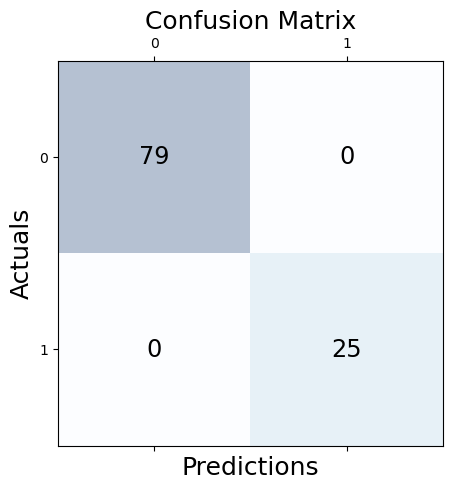

In [330]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## XGBoost on Hurricane Ian Data

In [366]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
xgb = xgb.XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [379]:
all_ian.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,ian,9/28/2022,38.027300,57.93571,12877,65287.07867,76710.34737,17.496982,1
98,Fort Pierce,ian,9/28/2022,50.039453,100.66050,529,79706.02938,93971.25035,17.897292,1
179,Lakeland,ian,9/28/2022,51.538176,105.13430,105,92333.43871,109089.32580,18.147149,1
188,Leesburg,ian,9/29/2022,48.540730,91.48921,1024,89188.23594,102166.59930,14.551654,1
203,Miami,ian,9/28/2022,41.539233,69.56759,20,187941.97110,204898.39500,9.022159,0


In [380]:
#y is prediction variable 
#X is features 
y_boost = all_ian['increase']
X_boost = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)


In [381]:
xgb.fit(X_boost, y_boost);

In [385]:
y_pred = xgb.predict(X_boost)

In [386]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_boost, y_pred))

Accuracy: 0.963


In [387]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 0.750


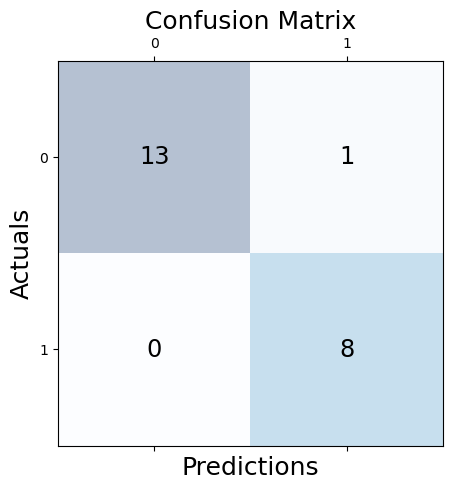

In [388]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#### Precision 
"Precision measures the proportion of true positive predictions made by the model (i.e. the number of correct positive predictions divided by the total number of positive predictions). It is a useful metric for evaluating the model’s ability to avoid false positives."

#### Recall
"Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made. For example: If your machine learning model is trying to identify positive reviews, the recall score would be what percent of those positive reviews did your machine learning model correctly predict as a positive. In other words, it measures how good our machine learning model is at identifying all actual positives out of all positives that exist within a dataset. Recall is also known as sensitivity or the true positive rate."

"Recall score can be used in the scenario where the labels are not equally divided among classes. For example, if there is a class imbalance ratio of 20:80 (imbalanced data), then the recall score will be more useful than accuracy because it can provide information about how well the machine learning model identified rarer events."



#### Accuracy
Accuracy metrics only considers the number of correct predictions (true positives and true negatives) made by the model.